In [44]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import re
import squarify

from functions import run_proportional_scaling, run_linear_programming, save_data_to_time_series
from helpers import fetch_area_data, get_variables
from tree import build_tree, fetch_branch, fetch_values_given_key, get_subindustries_data, get_constraints, write_into
from config import settings

In [45]:
print('51163 Rockbridge County, Virginia')
df, url = fetch_area_data('2021',4,'51163')

51163 Rockbridge County, Virginia


In [46]:
# https://www.bls.gov/cew/classifications/aggregation/agg-level-titles.htm
total_establishments = int(df[df['agglvl_code']==70][settings.establishments])
print(f"Total establishments in the county: {total_establishments}") 
aggregations = range(74,78+1)
for aggregation in aggregations:
    print(f"The sum of establishment counts at level {aggregation}: {np.sum(df[df['agglvl_code']==aggregation][settings.establishments])}")

Total establishments in the county: 542
The sum of establishment counts at level 74: 542
The sum of establishment counts at level 75: 542
The sum of establishment counts at level 76: 542
The sum of establishment counts at level 77: 542
The sum of establishment counts at level 78: 542


In [47]:
# cast data into a tree structure with nested mappings
# county = {'ind': 10, 'est': 533, 'emp': 5937, children': [{}, {}, ...]}
county = build_tree(df, '10', 71)

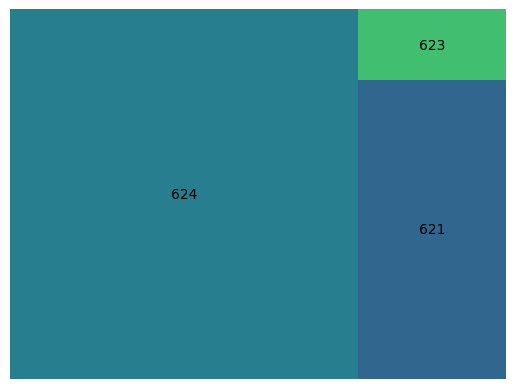

In [33]:
# Return industry details
industry = fetch_branch(county, 'ind', '62')
sub_industries = [sub_industry['ind'] for sub_industry in industry['children']]
est = [sub_industry['est'] for sub_industry in industry['children']]

sub_industries_sorted = [ind for _, ind in sorted(zip(est, sub_industries), reverse=True)]
est_sorted = sorted(est, reverse=True)
squarify.plot(sizes=est_sorted, label=sub_industries_sorted)
plt.axis('off')
plt.show()

In [48]:
# Proportional scaling example
industry = fetch_branch(county, 'ind', '10')
print('*** overall number of establishments ***')
print(industry['est'])
print('*** overall employment ***')
print(industry['emp'])
print('*** sub industries ***')
print([sub_industry['ind'] for sub_industry in industry['children']])
print('*** number of establishments in the sub industries ***')
print([sub_industry['est'] for sub_industry in industry['children']])
print('*** employment in the sub industries ***')
print([sub_industry['emp'] for sub_industry in industry['children']])
print('*** employment approximation proportional scaling ***')
establishments = np.array([sub_industry['est'] for sub_industry in industry['children']])
employment = np.array([sub_industry['emp'] for sub_industry in industry['children']],dtype = object)
employment_ps = employment.copy()
undisclosed_est = np.sum(establishments[np.where(employment==0)])
undisclosed_emp = industry['emp'] - np.sum(employment)
employment_ps[np.where(employment==0)] = establishments[np.where(employment==0)]/undisclosed_est*undisclosed_emp
print(employment_ps)
print('*** wages in the sub industries ***')
print([sub_industry['wages'] for sub_industry in industry['children']])
print('*** wages approximation proportional scaling ***')
establishments = np.array([sub_industry['est'] for sub_industry in industry['children']])
wages = np.array([sub_industry['wages'] for sub_industry in industry['children']],dtype = object)
wages_ps = wages.copy()
undisclosed_est = np.sum(establishments[np.where(wages==0)])
undisclosed_wages = industry['wages'] - np.sum(wages)
wages_ps[np.where(wages==0)] = establishments[np.where(wages==0)]/undisclosed_est*undisclosed_wages
print(wages_ps)



*** overall number of establishments ***
512
*** overall employment ***
4752
*** sub industries ***
['11', '21', '22', '23', '31_33', '42', '44_45', '48_49', '51', '52', '53', '54', '55', '56', '61', '62', '71', '72', '81', '99']
*** number of establishments in the sub industries ***
[17, 1, 2, 74, 25, 13, 62, 17, 9, 18, 9, 33, 2, 26, 5, 87, 13, 46, 41, 12]
*** employment in the sub industries ***
[0, 0, 0, 369, 897, 0, 1196, 77, 29, 106, 18, 0, 0, 0, 69, 507, 112, 584, 148, 17]
*** employment approximation proportional scaling ***
[112.67021276595746 6.627659574468085 13.25531914893617 369 897
 86.15957446808511 1196 77 29 106 18 218.7127659574468 13.25531914893617
 172.31914893617022 69 507 112 584 148 17]
*** wages in the sub industries ***
[0, 0, 0, 5804030, 10083092, 0, 9508668, 1079078, 400983, 1485148, 279793, 0, 0, 0, 683429, 5824644, 1057960, 3722327, 1286572, 142041]
*** wages approximation proportional scaling ***
[1471543.510638298 86561.3829787234 173122.7659574468 5804030

In [35]:
fig = go.Figure()
fig.add_trace(
    go.Bar(
        y = employment,
        name = 'employment'
    )
)
fig.add_trace(
    go.Bar(
        y = employment_ps,
        name = 'employment ps'
    )
)
fig.update_layout(
    title='Employment and employment approximation',
    width=800,
    height=450,
    legend=dict(
                y=0.99,
                x=0.01
                )
)

In [36]:
fig = go.Figure()
fig.add_trace(
    go.Bar(
        y = wages,
        name = 'wages'
    )
)
fig.add_trace(
    go.Bar(
        y = wages_ps,
        name = 'wages ps'
    )
)
fig.update_layout(
    title='Wages and wages approximation',
    width=800,
    height=450,
    legend=dict(
                y=0.99,
                x=0.01
                )
)

In [49]:
# loop through the entire tree
for ind in fetch_values_given_key(county, 'ind', []):
    industry = fetch_branch(county, 'ind', ind)
    data = get_subindustries_data(industry)
    county = run_proportional_scaling(county, industry, data)

In [50]:
# Define constraints
constraints = get_constraints(county, 'emp', [])

# Define variables
variables = []
for constraint in constraints:
    variables+=re.findall(r"epe_[^ ]* ", constraint)
for variable in list(np.unique(variables)):
    exec(f"{variable} = cp.Variable()")

# Define the objective function
exec(f"objective = cp.Minimize(cp.abs({constraints[0].replace('=', '-').replace('+', '-')}))")

# Define numerical constraints
numerical_constraints = []
for i,constraint in enumerate(constraints):
    if i > 0:
        numerical_constraints.append(eval(f"{constraint.replace('=','==')}"))
# Adding non-negativity constraints for the variables
for variable in list(np.unique(variables)):
    numerical_constraints.append(eval(f"{variable}>= 0"))

# Form and solve the problem
problem = cp.Problem(objective, numerical_constraints)
problem.solve()

2.5011104298755527e-12

In [51]:
for variable in variables:
    ind = variable[variable.find('_')+1:-1]
    branch = fetch_branch(county, 'ind', ind)
    if branch['emp'] == 0:
        write_into(
            county, 'ind', branch['ind'],
            {'emp_lp': branch['est'] * eval(f"float({variable}.value)")}
        )


In [58]:
industry = fetch_branch(county, 'ind', '31_33')
print(industry)
print(industry['est'])
print(industry['emp'])
if industry.get('emp_ps') is not None:
    print(f"emp_ps {industry['emp_ps']}")
if industry.get('emp_lp') is not None:
    print(f"emp_lp {industry['emp_lp']}")
for child in industry['children']:
    print(f"*** ind {child['ind']} *** ")
    print(child['est'])
    print(child['emp'])
    if child.get('emp_ps') is not None:
        print(f"emp_ps {child['emp_ps']}")
    if child.get('emp_lp') is not None:
        print(f"emp_lp {child['emp_lp']}")

{'ind': '31_33', 'est': 25, 'emp': 897, 'wages': 10083092, 'children': []}
25
897


In [41]:
# Fetch all industry codes in a period
county_code = '51163'
years = list(range(2014,2021+1))
industry_codes = []
for year in years:
    df, url = fetch_area_data(year,4,county_code)
    county = build_tree(df, '10', 71)
    industry_codes+=fetch_values_given_key(county, 'ind', [])
time_series = pd.DataFrame([], columns=np.unique(industry_codes)) 

In [42]:
# Run LP on all industries and all the years and save to time_series
for year in years:
    df, url = fetch_area_data(year,4,county_code)
    county = build_tree(df, '10', 71)
    county = run_linear_programming(county, 'emp')
    for ind in industry_codes:
        industry = fetch_branch(county, 'ind', ind)
        if industry is not None:
            if industry.get('emp_lp') is not None:
                time_series.at[year, ind] = industry['emp_lp']
            else:
                time_series.at[year, ind] = industry['emp']

KeyboardInterrupt: 

In [ ]:
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x = years,
        y = time_series['5221']
    )
)
fig.update_layout(
    title='Employment approximation with LP',
    width=800,
    height=450,
    legend=dict(
                y=0.99,
                x=0.01
                )
)

In [ ]:
time_series.pct_change().std().sort_values(ascending=False)[0:20]

238351    3.277609e+14
23835     3.182216e+14
5411      3.081535e+00
54111     3.081535e+00
541110    3.081535e+00
236115    3.067591e+00
611620    2.843151e+00
61162     2.843151e+00
531110    2.808901e+00
53111     2.808901e+00
5311      2.808901e+00
53131     2.695238e+00
5313      2.676293e+00
541519    2.553907e+00
71394     2.386531e+00
713940    2.386531e+00
611610    2.347770e+00
61161     2.347770e+00
61        2.178524e+00
611       2.178524e+00
dtype: float64

In [ ]:
time_series.to_csv('Rockbridge.csv')

In [ ]:
# Fetch all industry codes in a period
county_code = '13121'
years = list(range(2014,2021+1))
industry_codes = []
for year in years:
    df, url = fetch_area_data(year,4,county_code)
    county = build_tree(df, '10', 71)
    industry_codes+=fetch_values_given_key(county, 'ind', [])
employment_series = pd.DataFrame([], columns=np.unique(industry_codes))
wages_series = pd.DataFrame([], columns=np.unique(industry_codes))

# Run LP on all industries and all the years and save to time_series
for year in years:
    df, url = fetch_area_data(year,4,county_code)
    county = build_tree(df, '10', 71)
    county = run_linear_programming(county, 'emp')
    county = run_linear_programming(county, 'wages')
    employment_series = save_data_to_time_series(
        employment_series, county, industry_codes, 'emp', year
    )    
    wages_series = save_data_to_time_series(
        wages_series, county, industry_codes, 'wages', year
    )

/Users/nikolamirkov/Upwork/20221229 QCEW/QCEW-Project/env/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.

/Users/nikolamirkov/Upwork/20221229 QCEW/QCEW-Project/env/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.

/Users/nikolamirkov/Upwork/20221229 QCEW/QCEW-Project/env/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.

/Users/nikolamirkov/Upwork/20221229 QCEW/QCEW-Project/env/lib/python3.10/site-packages/cvxpy/problems/problem.py:1385: UserWarning:

Solution may be inaccurate. Try another solver, adjusting the solver settings, or

In [ ]:
employment_series

,10,11,111,1112,11121,111219,1113,11133,111335,111336,...,813990,814,8141,81411,814110,99,999,9999,99999,999999
2014,693762,221,78,45.791451,45.791451,45.791451,NaN,NaN,NaN,NaN,...,485,1234,1234,1234,1234,3513,3513,3513,3513,3513
2015,712929,192,35,3.286808,3.286808,3.286808,NaN,NaN,NaN,NaN,...,480,1160,1160,1160,1160,2543,2543,2543,2543,2543
2016,746100,167,39,4.5,4.5,4.5,NaN,NaN,NaN,NaN,...,475,1141,1141,1141,1141,2828,2828,2828,2828,2828
2017,770613,146,28,4.297512,4.297512,4.297512,NaN,NaN,NaN,NaN,...,530,1067,1067,1067,1067,1698,1698,1698,1698,1698
2018,792765,155,33,5.174005,5.174005,5.174005,1.963402,1.963402,NaN,NaN,...,556,968,968,968,968,1543,1543,1543,1543,1543
2019,817859,155,46,2.800647,2.800647,2.800647,15,15,5.0,5.0,...,510,899,899,899,899,2204,2204,2204,2204,2204
2020,758087,161,38,6.812418,6.812418,6.812418,6.187582,6.187582,2.062527,2.062527,...,523,761,761,761,761,1819,1819,1819,1819,1819
2021,810204,188,71,10.599196,10.599196,10.599196,4.400804,4.400804,2.200402,NaN,...,559,730,730,730,730,3285,3285,3285,3285,3285


In [ ]:
employment_series.pct_change().std().sort_values(ascending=False)[0:20]

52592     14.424766
525920    14.424766
53221      4.833541
532210     4.833541
562119     4.659091
212324     4.574248
238132     4.490326
21232      4.170093
11133      4.089175
1113       4.089175
238122     3.323646
23812      3.323646
711410     3.200415
71141      3.200415
7114       3.200415
517919     3.093481
512210     3.006475
51221      3.006475
532282     2.770730
813940     2.649325
dtype: float64

In [ ]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x = years,
        y = employment_series['713950'],
        name = 'disclosed'
    )
)
fig.add_trace(
    go.Scatter(
        x = years[-2:],
        y = employment_series['713950'].iloc[-2:],
        name = 'undisclosed'

    )
)
fig.update_layout(
    title='Employment in Bowling Centers (713950), Fulton Georgia',
    width=800,
    height=450,
    legend=dict(
                y=0.99,
                x=0.01
                )
)

In [ ]:
employment_series.columns = employment_series.columns.str.replace('_', '-')
employment_series.to_csv('Fulton_employment.csv')

In [ ]:
wages_series.pct_change().std().sort_values(ascending=False)[0:20]

525920    41.118245
52592     41.118245
238291    22.750606
238132    14.996680
711212    10.773849
7114       7.208209
71141      7.208209
711410     7.208209
525990     5.864774
52599      5.864774
111998     5.583609
11199      5.583609
562119     5.377399
532210     4.884810
53221      4.884810
517919     4.705547
525910     4.167408
52591      4.167408
512199     4.042671
5259       4.005770
dtype: float64

In [ ]:
wages_series.columns = wages_series.columns.str.replace('_', '-')
wages_series.to_csv('Fulton_wages.csv')